In [27]:
using Bloqade
using Random
using PythonCall
using Optim
plt = pyimport("matplotlib.pyplot");

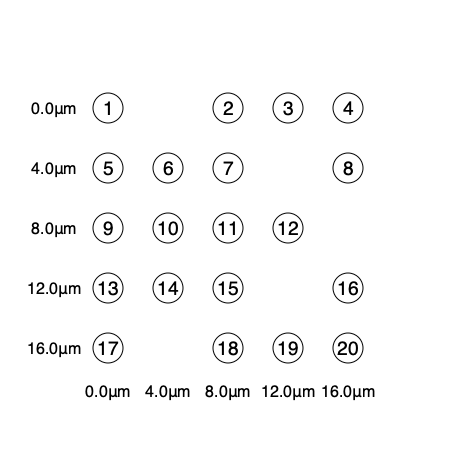

In [29]:
Random.seed!(22)
a=4
atoms = generate_sites(SquareLattice(), 5,5; scale = a) |> random_dropout(0.2)

In [30]:
Rb=sqrt(3*sqrt(10))*a

12.320281152964093

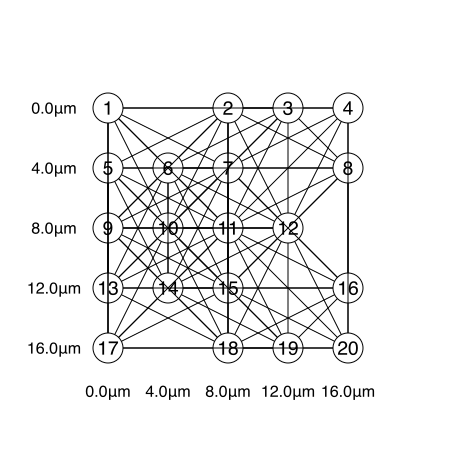

In [31]:
Bloqade.plot(atoms, blockade_radius = Rb)

In [32]:
function loss_piecewise_linear(atoms::AtomList, x::AbstractVector{T}) where {T}
    @assert length(x) == 5
    C6 = 2π*862690
    Ω_max = 2π*2.5
    Δ_end = C6 / Rb^6
    Δ_start = -2π*10
    Δ0 = Δ_end
    T_max = 0.8

    # the strength of the detunings at each step takes the optimizing x as their input
    Δs = piecewise_linear(clocks = T[0.0, 0.05, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75, T_max],
            values = T[Δ_start, Δ_start, Δ0*x[1], Δ0*x[2], Δ0*x[3], Δ0*x[4], Δ0*x[5], Δ_end, Δ_end])
    Ωs = piecewise_linear(clocks = T[0.0, 0.05, 0.1, 0.2, 0.6, 0.7, 0.75, T_max], values = T[0, 0, 0, Ω_max, Ω_max, 0, 0, 0])

    hamiltonian = rydberg_h(atoms; Ω = Ωs, Δ = Δs)
    subspace = blockade_subspace(atoms, Rb)
    prob = SchrodingerProblem(zero_state(Complex{T}, subspace), T_max, hamiltonian)
    emulate!(prob)
    return -rydberg_density_sum(prob.reg), prob.reg, Ωs, Δs
end

loss_piecewise_linear (generic function with 1 method)

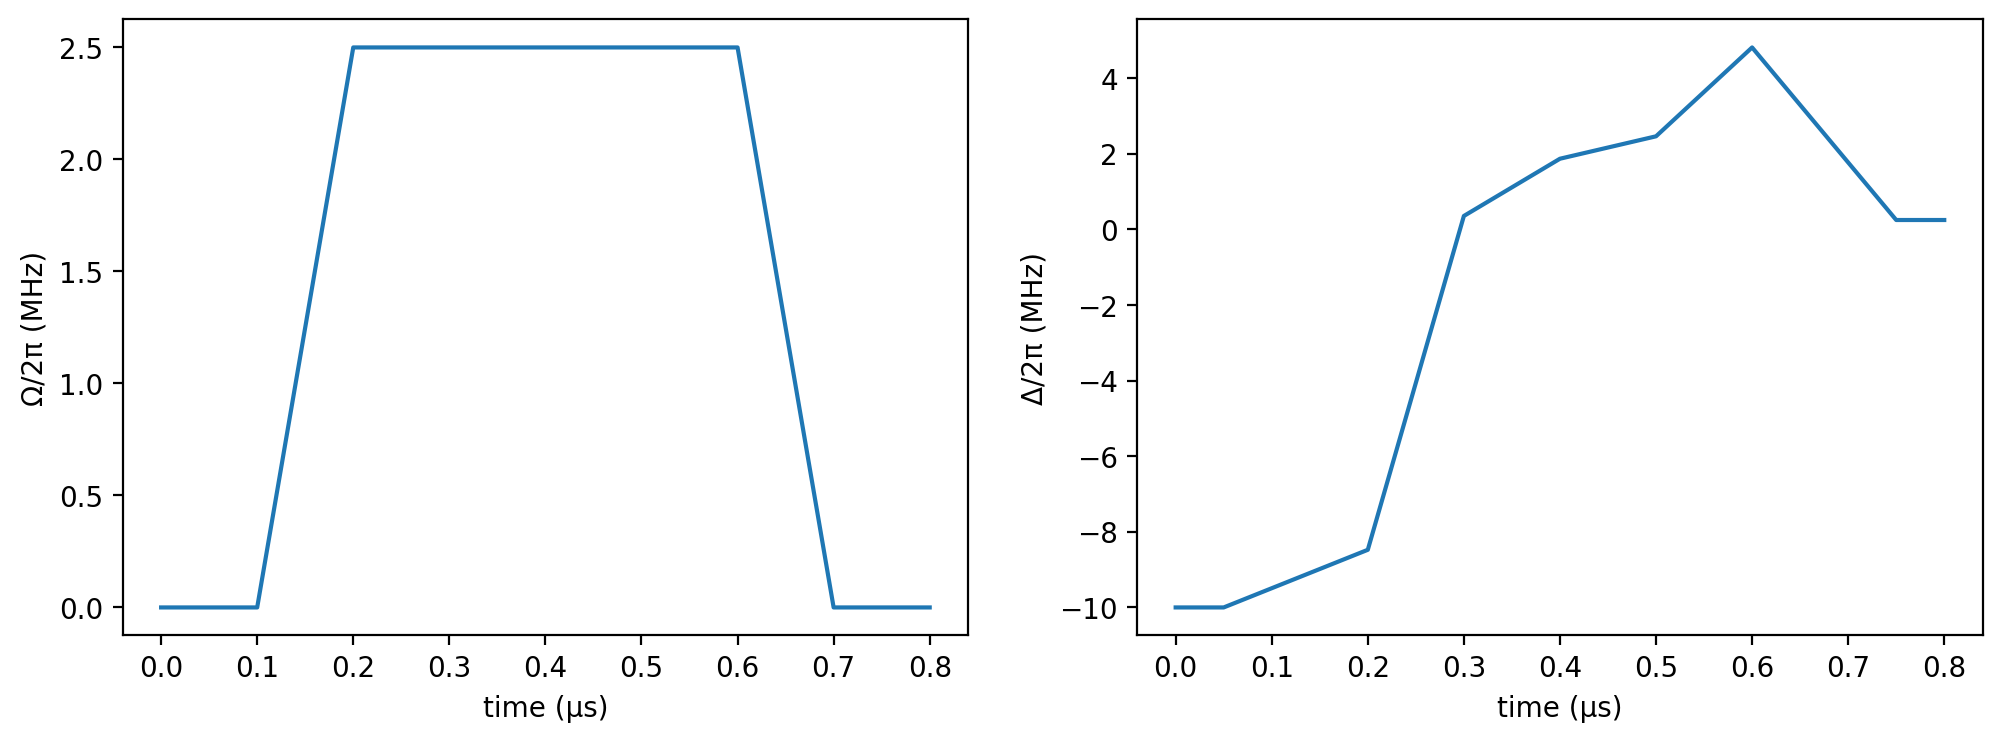

In [33]:
#=x0 = [-6.0, -3.0, 1.0, 3.0, 6.0]; # initial point for the optimization
optresult = Optim.optimize(x -> loss_piecewise_linear(atoms, x)[1], x0)=#
x = [-34.357805747236654, 1.4329770373209492, 7.5693393460213, 9.973535516555557, 19.50077146687081]
rydberg_dens, reg, Ω, Δ = loss_piecewise_linear(atoms, x)#optresult.minimizer)

# graph to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

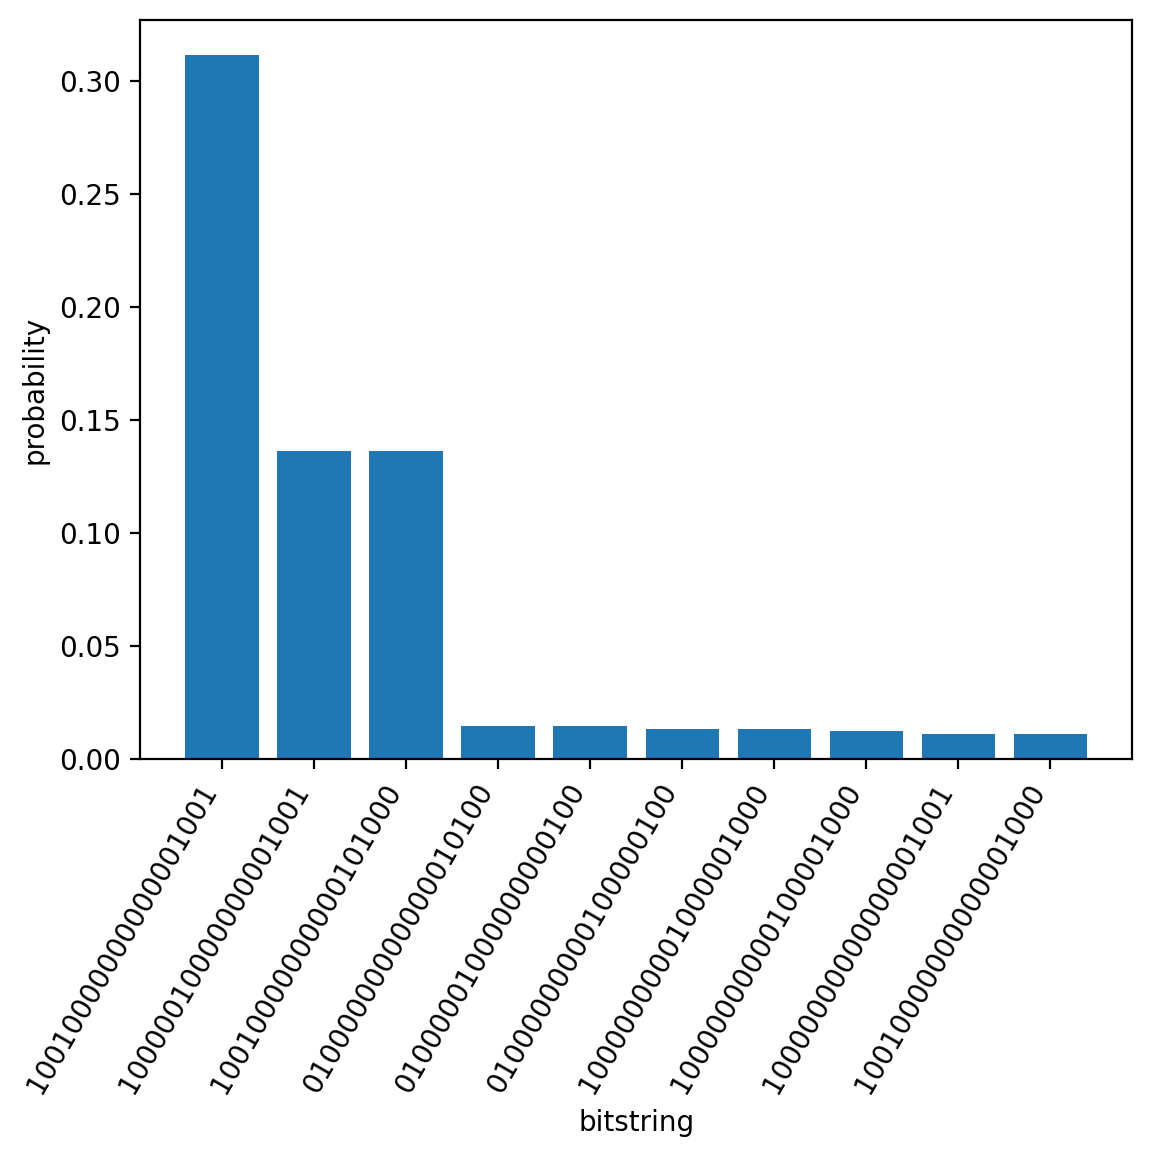

In [34]:
bitstring_hist(reg; nlargest = 10)

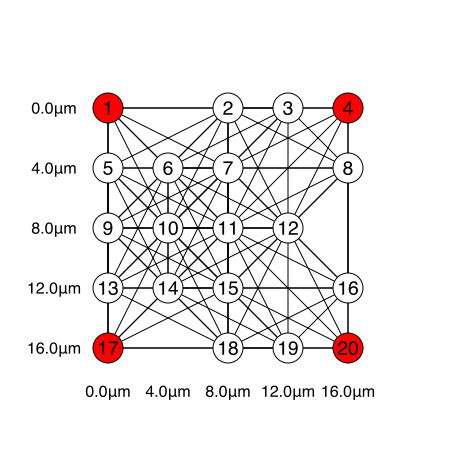

In [35]:
best_bit_strings = most_probable(reg, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])

In [36]:
using GenericTensorNetworks
graph = BloqadeMIS.unit_disk_graph(atoms, Rb)
problem = IndependentSet(graph; optimizer=TreeSA())
all_max_configs = GenericTensorNetworks.solve(problem, ConfigsMax(; bounded=false))[]

(4.0, {10010000000000001001, 10010000000001000001, 00010100000000001001})ₜ